# Imports

In [1]:
import requests
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt

In [2]:
import gdown
import zipfile
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load the data zip file to colab

In [4]:
!pip install gdown --quiet

In [5]:
# Google Drive file ID
file_id = "1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp"
zip_path = "lfwa.zip"
output_dir = "/content/lfw"

In [6]:
# Download the zip file
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
From (redirected): https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp&confirm=t&uuid=52f4f58f-958d-4df3-bb16-13fddb170c1c
To: /content/lfwa.zip
100%|██████████| 104M/104M [00:01<00:00, 67.0MB/s]


In [7]:
# Verify extraction
if not os.path.exists(output_dir):
    raise FileNotFoundError("Dataset extraction failed.")
else:
    print(f"Dataset extracted to: {output_dir}")

Dataset extracted to: /content/lfw


In [8]:
root_dir = "/content/lfw/lfw2/lfw2"

# Data

In [9]:
class LFWPairsDataset(Dataset):
    def __init__(self, root, transform=None, pairs_file=None):
        """
        Initialize the LFWPairs dataset.
        Args:
            root (str): Root directory containing LFW images.
            transform (callable, optional): Transform to apply to images.
            pairs_file (str): Path or URL to the pairs file.
        """
        self.root = root
        self.transform = transform
        self.pairs = self._load_pairs(pairs_file)

    def _load_pairs(self, pairs_file):
        """
        Load pairs from a local file or URL.
        """
        if pairs_file.startswith("http"):
            response = requests.get(pairs_file, verify=False)
            response.raise_for_status()  # making sure the request was successful
            lines = response.text.strip().split('\n')[1:]  # Skip the first line (number of pairs)

        pairs = []
        for line in lines:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                # Same person, two images
                name = parts[0]
                img1_idx = parts[1].zfill(4)  # Ensure 4 digits
                img2_idx = parts[2].zfill(4)  # Ensure 4 digits
                label = 1  # Same person
            elif len(parts) == 4:
                # Different people
                name1 = parts[0]
                name2 = parts[2]
                img1_idx = parts[1].zfill(4)  # Ensure 4 digits
                img2_idx = parts[3].zfill(4)  # Ensure 4 digits
                label = 0  # Different people

            if len(parts) == 3:
                img1_path = os.path.join(self.root, f"{name}/{name}_{img1_idx}.jpg")
                img2_path = os.path.join(self.root, f"{name}/{name}_{img2_idx}.jpg")
            elif len(parts) == 4:
                img1_path = os.path.join(self.root, f"{name1}/{name1}_{img1_idx}.jpg")
                img2_path = os.path.join(self.root, f"{name2}/{name2}_{img2_idx}.jpg")

            pairs.append((img1_path, img2_path, label))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), label

In [10]:
# URLs for pairs
train_pairs_url = "https://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
test_pairs_url = "https://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"

# Transformations
transform = transforms.Compose([
    transforms.Resize((105, 105)),  # the input size is: 150X150, we resize to: 105X105 - as seen in the paper.
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Dataset preparation
train_dataset = LFWPairsDataset(root=root_dir, transform=transform, pairs_file=train_pairs_url)
test_dataset = LFWPairsDataset(root=root_dir, transform=transform, pairs_file=test_pairs_url)

# Define the split ratio for training and validation
train_size = int(0.9 * len(train_dataset))  # 90% for training
val_size = len(train_dataset) - train_size  # 10% for validation

# Split the dataset to train and validation:
generator1 = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator1)

# DataLoader, batch size is 64:
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vis-www.cs.umass.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vis-www.cs.umass.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [11]:
print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 1980
Validation set size: 220
Test set size: 1000


In [12]:
# Validate DataLoader
for i, ((img1, img2), labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print(f"Image 1 batch shape: {img1.shape}")
    print(f"Image 2 batch shape: {img2.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break

Batch 1
Image 1 batch shape: torch.Size([64, 1, 105, 105])
Image 2 batch shape: torch.Size([64, 1, 105, 105])
Labels batch shape: torch.Size([64])


In [13]:
# Function to analyze the dataset with label separation
def analyze_dataset(dataset, name):
    total_samples = len(dataset)
    label_counts = {0: 0, 1: 0}  # Initialize counters for each label

    for _, label in dataset:
        label_counts[label] += 1

    print(f"--- {name} Dataset Analysis ---")
    print(f"Total Samples: {total_samples}")
    for label, count in label_counts.items():
        print(f"Label {label} (Count): {count}")
    print("\n")

# Analyze datasets
print("Analyzing datasets...")
analyze_dataset(train_subset, "Training")
analyze_dataset(val_subset, "Validation")
analyze_dataset(test_dataset, "Testing")

Analyzing datasets...
--- Training Dataset Analysis ---
Total Samples: 1980
Label 0 (Count): 995
Label 1 (Count): 985


--- Validation Dataset Analysis ---
Total Samples: 220
Label 0 (Count): 105
Label 1 (Count): 115


--- Testing Dataset Analysis ---
Total Samples: 1000
Label 0 (Count): 500
Label 1 (Count): 500




# Hyper-Parameters selection

epochs, learning rate, etc.

In [14]:
max_epochs = 100
min_learning_rate = 0.0001
batch_size = batch_size # 64

# Siamese network architecture

We used the original article as a reference for the network structure:

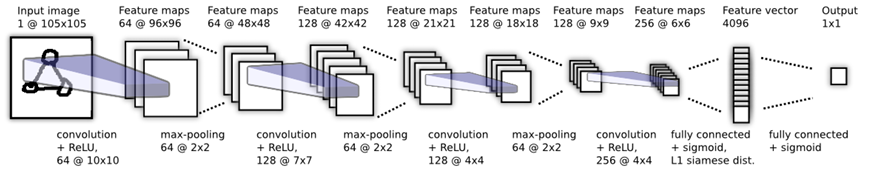

In [15]:
class Siamese_Model(nn.Module):
    """
    Siamese Neural Network for One-Shot Image Recognition.

    The model consists of:
    1. `part1`: Shared convolutional feature extraction network. [ Conv + ReLU + BatchNorm + MaxPool + Dropout ]
    2. `part2`: Fully connected layers to calculate similarity between two feature vectors.
    """
    def __init__(self):
        super(Siamese_Model, self).__init__()

        # Shared feature extraction network
        self.part1 = nn.Sequential(
            # Layer 1:
            nn.Conv2d(1, 64, kernel_size=10, stride=1), # original: in_channels=1, out_channels=64  // reduced: in_channels=1, out_channels=32
            nn.ReLU(),
            nn.BatchNorm2d(64), # original: 64  // reduced: 32
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Layer 2:
            nn.Conv2d(64, 128, kernel_size=7, stride=1), # original: in_channels=64, out_channels=128  // reduced: in_channels=32, out_channels=32
            nn.ReLU(),
            nn.BatchNorm2d(128), # original: 128  // reduced: 32
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Layer 3:
            nn.Conv2d(128, 128, kernel_size=4, stride=1), # original: in_channels=128, out_channels=128  // reduced: in_channels=32, out_channels=32
            nn.ReLU(),
            nn.BatchNorm2d(128), # original: 128  // reduced: 32
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Layer 4:
            nn.Conv2d(128, 256, kernel_size=4, stride=1), # original: in_channels=128, out_channels=256  // reduced: in_channels=32, out_channels=32
            nn.ReLU(),
            nn.BatchNorm2d(256), # original: 256  // reduced: 32
            nn.Dropout(0.3),

            # Flatten and Fully Connected Layer
            nn.Flatten(),  #Original Output: 256 * 6 * 6 = 9216
            nn.Linear(256 * 6 * 6, 32),   # original: 256 x 6 x6 = 9,216 -> 4,096 (like the original paper) // reduced: 32 * 6 * 6
            nn.Dropout(0.3)  # Dropout before the final fully connected layer
        ).apply(init_weights)

        # Similarity Calculation
        self.part2 = nn.Sequential(
            nn.Linear(32, 1), # original: (4096,1)
            nn.Sigmoid()
        )

    def forward(self, one, two):
        """
        Forward pass for the Siamese Network.

        Args:
        - one (torch.Tensor): First input image batch (B, C, H, W).
        - two (torch.Tensor): Second input image batch (B, C, H, W).

        Returns:
        - torch.Tensor: Similarity score for each pair of inputs.
        """
        # Pass both inputs through the shared network
        one = self.part1(one)
        two = self.part1(two)

        # Compute absolute difference and pass through fully connected layers
        final = self.part2(torch.abs(one - two))
        return final


In [16]:
################ NOT USED - Like the original articl ################

# @torch.no_grad()
# def init_weights(m):
#     """
#     Custom weight initialization based on the paper, using truncated normal distribution (for stability issues):
#     - Convolutional layers:
#         - Weights: Truncated normal distribution with mean 0 and std 1e-2.
#         - Biases: Truncated normal distribution with mean 0.5 and std 1e-2.
#     - Fully connected layers:
#         - Weights: Truncated normal distribution with mean 0 and std 2e-1.
#         - Biases: Truncated normal distribution with mean 0.5 and std 1e-2.

#     Args:
#         m (torch.nn.Module): A layer in the network to initialize.

#     The description ein the original articl:
#     "Weight initialization: We initialized all network weights
#     in the convolutional layers from a normal distribution with zero-mean and a
#     standard deviation of 10−2. Biases were also initialized from a normal distribution,
#     but with mean 0.5 and standard deviation 10−2.
#     In the fully-connected layers, the biases were initialized in the same way as the convolutional layers,
#     but the weights were drawn from a much wider normal distribution with zero-mean and standard deviation 2 × 10−1."

#     """
#     if isinstance(m, nn.Conv2d):
#         # Convolutional layers
#         torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=1e-2)
#         if m.bias is not None:
#             torch.nn.init.trunc_normal_(m.bias, mean=0.5, std=1e-2)

#     elif isinstance(m, nn.Linear):
#         # Fully connected layers
#         torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=2e-1)
#         if m.bias is not None:
#             torch.nn.init.trunc_normal_(m.bias, mean=0.5, std=1e-2)

In [17]:
@torch.no_grad()
def init_weights(m):
    """
    Initialize weights for the network using Kaiming Uniform initialization.

    Args:
    - m (torch.nn.Module): Layer to initialize.
    """
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


# Initialize the model

In [18]:
# Initialize the model
model = Siamese_Model().to(device)

In [19]:
# Optimizer:

# Adam Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=min_learning_rate)

# SGD Optimizer: (as described in the paper)
# optimizer = torch.optim.SGD(model.parameters(),lr=min_learning_rate)

In [20]:
# Decreasing the learning rate factor by 1% after each epoch (like the original paper)
lmbda = lambda epoch: 0.99

# Learning rate scheduler:
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

# Loss function:
criterion = nn.BCELoss() # Binary Cross Entropy

In [21]:
print(model)

Siamese_Model(
  (part1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.3, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (16): ReLU()
    (17): B

# Train & Evaluate the Model

In [22]:
def apply_sigmoid_threshold(probabilities, threshold=0.5):
    """
    Converts probabilities into binary labels based on a threshold.

    Args:
        probabilities (torch.Tensor): Predicted probabilities (output of Sigmoid).
        threshold (float, optional): Threshold for classification. Defaults to 0.5.

    Returns:
        torch.Tensor: Binary labels (0 or 1).
    """
    return (probabilities > threshold).float()

In [23]:
def evaluate(model, dataloader, loss_fn):
    """
    Evaluates the model on a given dataset.

    Args:
        model (torch.nn.Module): The Siamese network model.
        dataloader (DataLoader): DataLoader for evaluation data.
        loss_fn (torch.nn.Module): Loss function to compute evaluation loss.

    Returns:
        dict: Dictionary containing average loss and accuracy.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient computation
        for (img1, img2), label in dataloader:
            # Move data to the appropriate device
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Forward pass
            predictions = model(img1, img2)

            # Compute loss
            loss = loss_fn(predictions.float(), label.unsqueeze(1).float())
            total_loss += loss.item()

            # Convert probabilities to binary predictions
            predicted_labels = apply_sigmoid_threshold(predictions.flatten())
            correct_predictions += (predicted_labels == label).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return {'loss': avg_loss, 'accuracy': accuracy}

In [24]:
def model_train_step(model, dataloader, optimizer, loss_fn):
    """
    Performs one training step (single epoch) for the given model.

    Args:
        model (torch.nn.Module): The Siamese network model.
        dataloader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        loss_fn (torch.nn.Module): Loss function to compute training loss.

    Returns:
        float: Average training loss for this epoch.
    """
    model.train()
    running_loss = 0.0

    for (img1, img2) , label in dataloader:
        # Move data to the appropriate device (GPU or CPU)
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Forward pass
        predictions = model(img1, img2)

        # Compute loss
        loss = loss_fn(predictions.float(), label.unsqueeze(1).float())

        # Backpropagation and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    return running_loss / len(dataloader)

In [25]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs, early_stopping_threshold=0.0001, patience=5):
    """
    Trains the Siamese network and evaluates it at each epoch.

    Args:
        model (torch.nn.Module): The Siamese network model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        loss_fn (torch.nn.Module): Loss function to compute loss.
        epochs (int): Number of epochs to train.
        early_stopping_threshold (float): Early stopping threshold for validation loss changes.
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        dict: Training and validation metrics (loss, accuracy) over all epochs.
    """
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}: ")

        # Training step
        train_loss = model_train_step(model, train_dataloader, optimizer, loss_fn)

        # Evaluate on training set
        train_metrics = evaluate(model, train_dataloader, loss_fn)
        train_loss_history.append(train_metrics['loss'])
        train_acc_history.append(train_metrics['accuracy'])

        # Evaluate on validation set
        val_metrics = evaluate(model, val_dataloader, loss_fn)
        val_loss_history.append(val_metrics['loss'])
        val_acc_history.append(val_metrics['accuracy'])

        print(f"Train Loss: {train_metrics['loss']:.4f}, Train Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"Validation Loss: {val_metrics['loss']:.4f}, Validation Accuracy: {val_metrics['accuracy']:.4f}")

        # Early stopping based on validation loss:
        if len(val_loss_history) >= patience:
            recent_improvement = abs(val_loss_history[-1] - val_loss_history[-patience])
            if recent_improvement < early_stopping_threshold:
                print("Early stopping due to lack of improvement.")
                break

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total Training Time: {total_time:.2f} seconds")

    # Return training and validation metrics for plotting
    return {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }

In [26]:
metrics = train_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=max_epochs
)

Epoch 1/100: 
Train Loss: 0.6857, Train Accuracy: 0.5429
Validation Loss: 0.7181, Validation Accuracy: 0.4909
Epoch 2/100: 
Train Loss: 0.6651, Train Accuracy: 0.6005
Validation Loss: 0.7363, Validation Accuracy: 0.4773
Epoch 3/100: 
Train Loss: 0.6499, Train Accuracy: 0.6207
Validation Loss: 0.7161, Validation Accuracy: 0.5182
Epoch 4/100: 
Train Loss: 0.6305, Train Accuracy: 0.6591
Validation Loss: 0.7011, Validation Accuracy: 0.5227
Epoch 5/100: 
Train Loss: 0.6196, Train Accuracy: 0.6687
Validation Loss: 0.6909, Validation Accuracy: 0.5318
Epoch 6/100: 
Train Loss: 0.6114, Train Accuracy: 0.6808
Validation Loss: 0.6827, Validation Accuracy: 0.5818
Epoch 7/100: 
Train Loss: 0.5940, Train Accuracy: 0.7010
Validation Loss: 0.6703, Validation Accuracy: 0.6000
Epoch 8/100: 
Train Loss: 0.5785, Train Accuracy: 0.7146
Validation Loss: 0.6680, Validation Accuracy: 0.5818
Epoch 9/100: 
Train Loss: 0.5681, Train Accuracy: 0.7253
Validation Loss: 0.6581, Validation Accuracy: 0.6091
Epoch 10/1

In [31]:
# Final evaluation on the test set
test_metrics = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_metrics['loss']:.6f}, Test Accuracy: {test_metrics['accuracy']:.6f}")

Test Loss: 0.639552, Test Accuracy: 0.659000


# Plot the Results

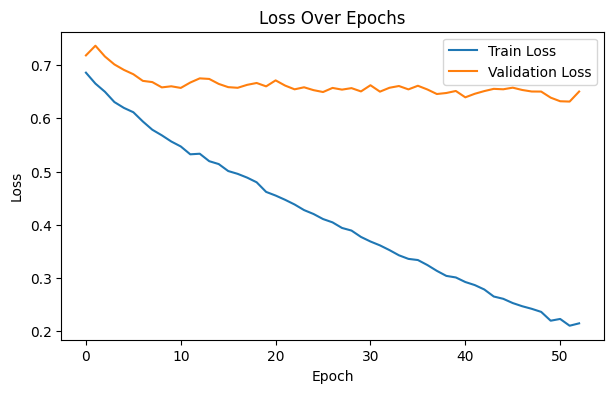

In [28]:
# Loss plot
plt.figure(figsize=(7,4))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

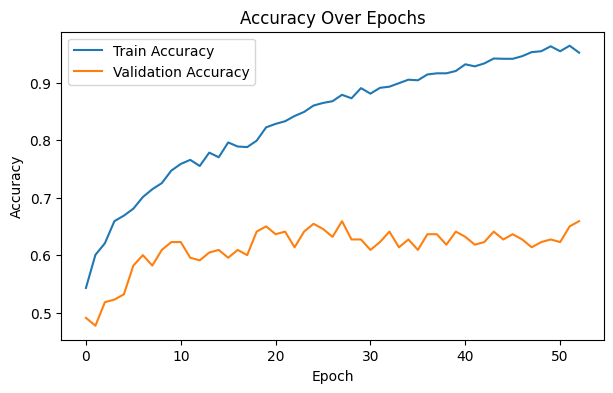

In [29]:
# Accuracy plot
plt.figure(figsize=(7,4))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Examples of accurate and misclassifications

In [34]:
def visualize_predictions(model, dataloader, device, num_examples=10):
    """
    Visualizes examples of accurate and misclassifications from the test set.

    Args:
        model (torch.nn.Module): Trained Siamese Network model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the test set.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_examples (int): Number of examples to visualize.
    """
    model.eval()  # Set the model to evaluation mode
    examples_shown = 0  # Track the number of examples visualized

    with torch.no_grad():  # Disable gradient calculations for inference
        for (img1, img2), label in dataloader:
            # Move data to the appropriate device
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Make predictions
            pred = model(img1, img2)
            prediction = round(float(pred[0]), 3)
            predicted_class = 1 if prediction > 0.5 else 0
            true_label = int(label[0].item())

            # Retrieve images for visualization
            im1, im2 = img1[0].cpu().numpy()[0], img2[0].cpu().numpy()[0]

            # Plot images and prediction details
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
            ax1.imshow(im1, cmap='gray')
            ax1.axis('off')
            ax1.set_title("Image 1")

            ax2.imshow(im2, cmap='gray')
            ax2.axis('off')
            ax2.set_title("Image 2")

            # Add title with prediction and ground truth
            fig.suptitle(
                f"Model Prediction: {prediction} ---> {predicted_class}\n"
                f"True Label: {true_label}",
                fontsize=12
            )
            plt.tight_layout()
            plt.show()

            # Check if the prediction matches the true label
            if predicted_class == true_label:
                print("Correct Classification")
            else:
                print("Misclassification")

            # Stop after displaying the specified number of examples
            examples_shown += 1
            if examples_shown >= num_examples:
                break


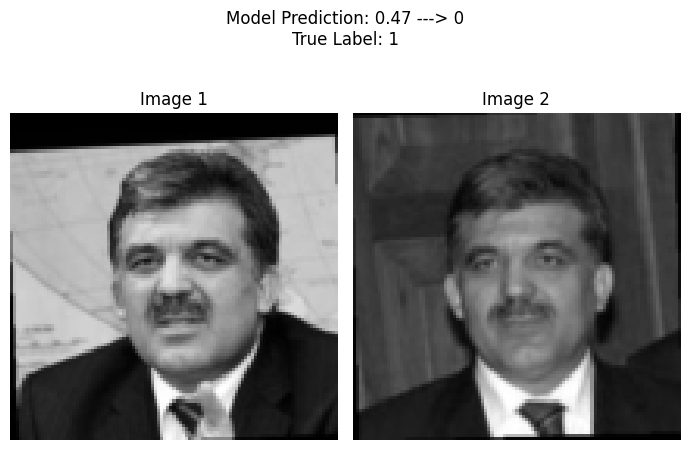

Misclassification


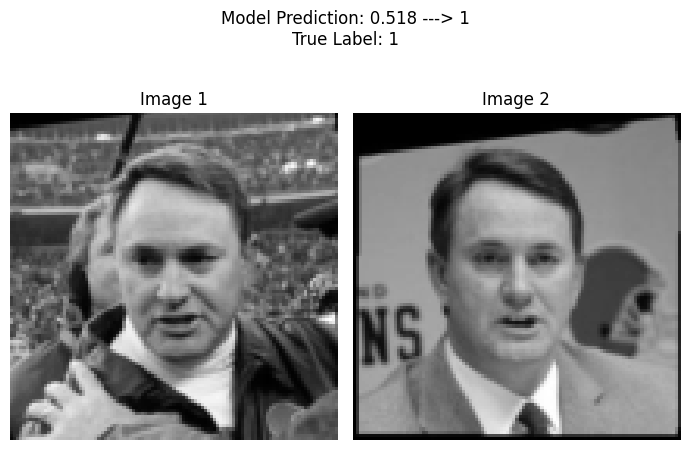

Correct Classification


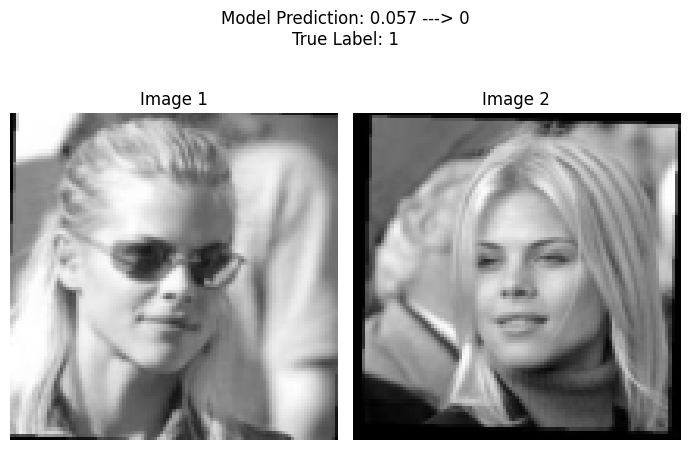

Misclassification


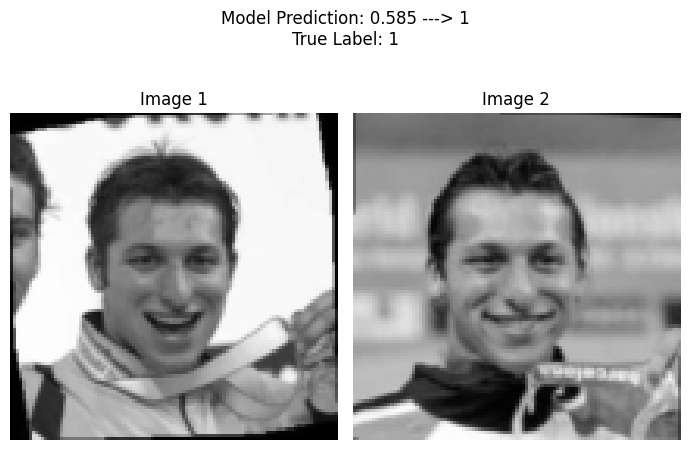

Correct Classification


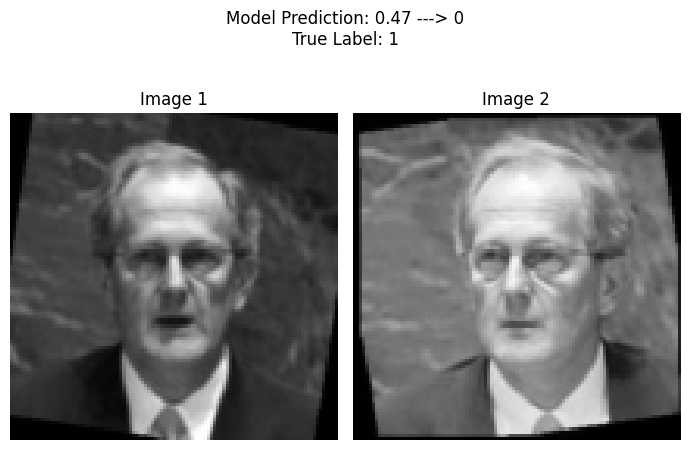

Misclassification


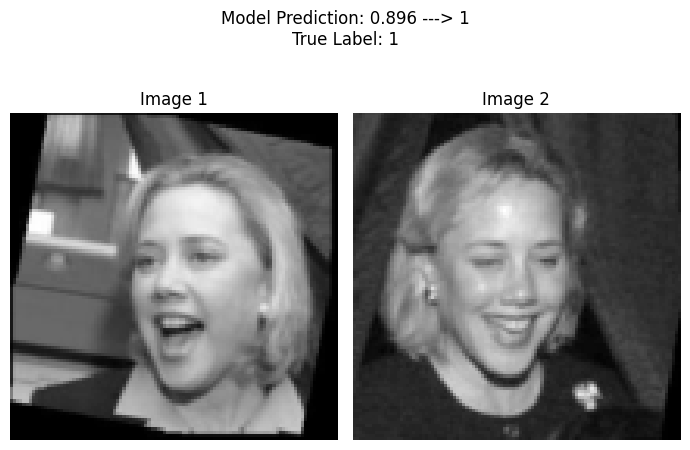

Correct Classification


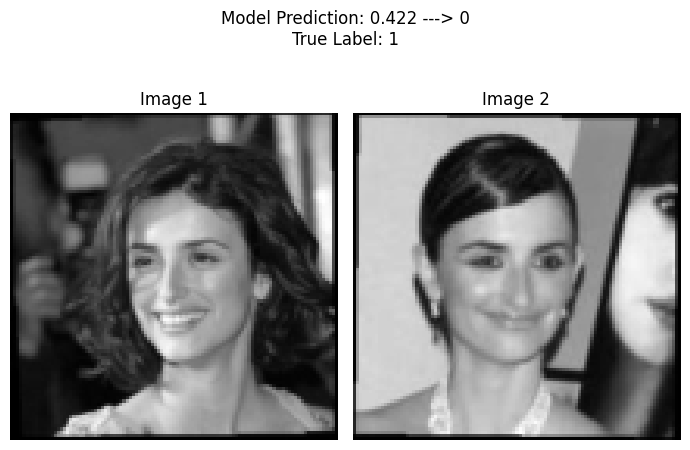

Misclassification


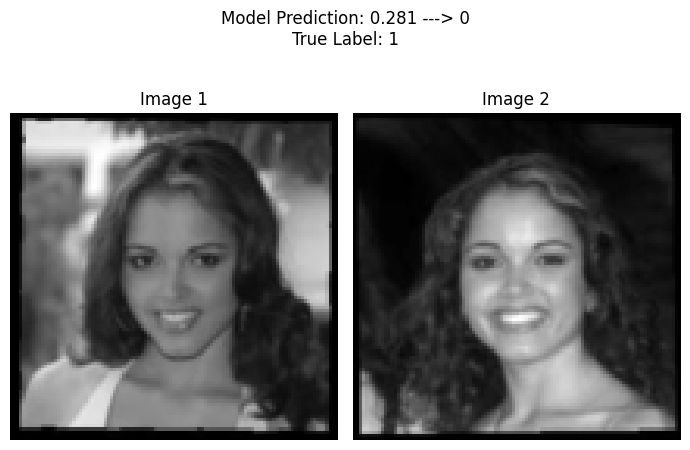

Misclassification


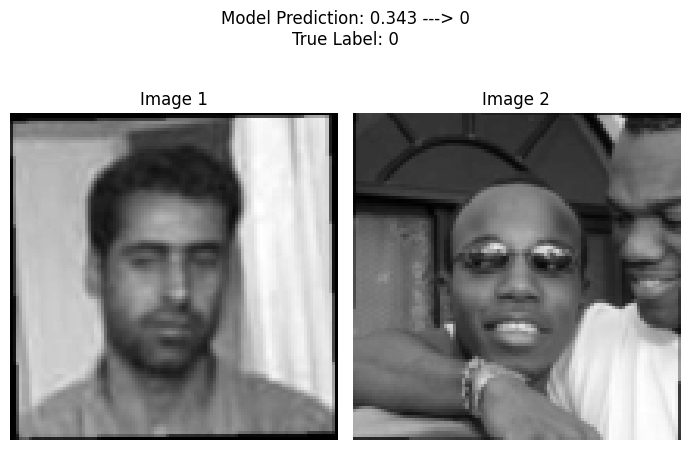

Correct Classification


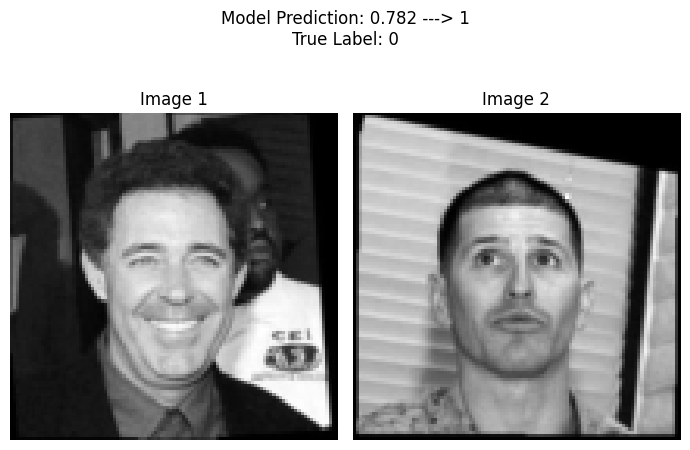

Misclassification


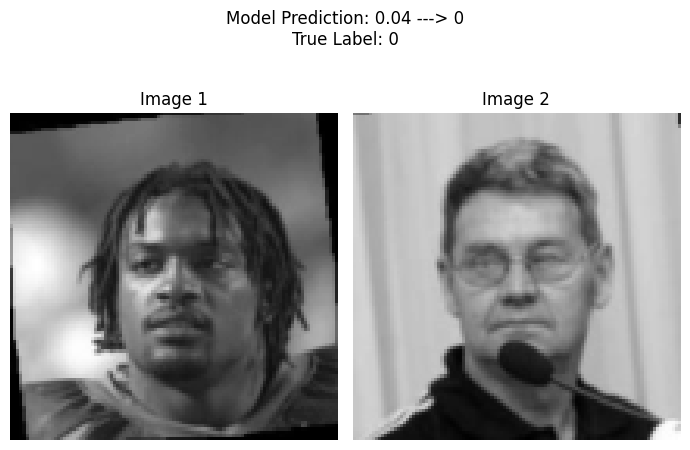

Correct Classification


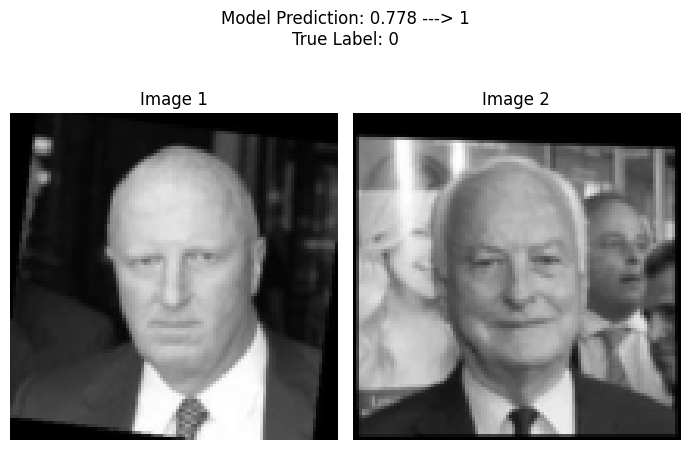

Misclassification


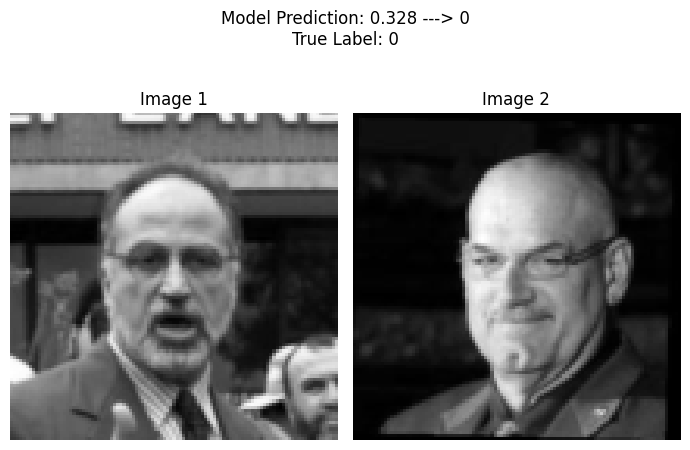

Correct Classification


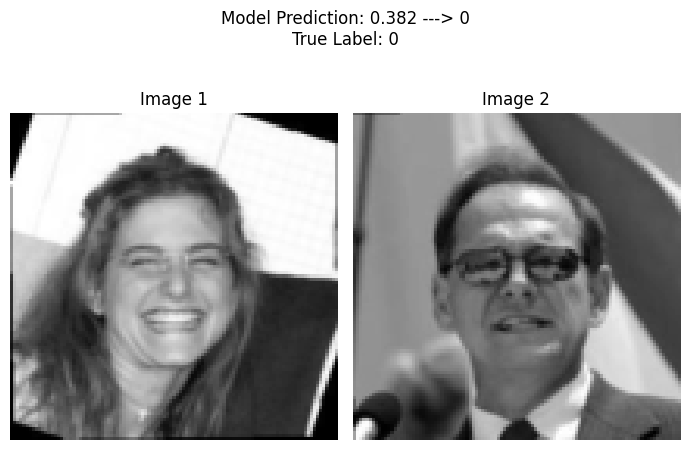

Correct Classification


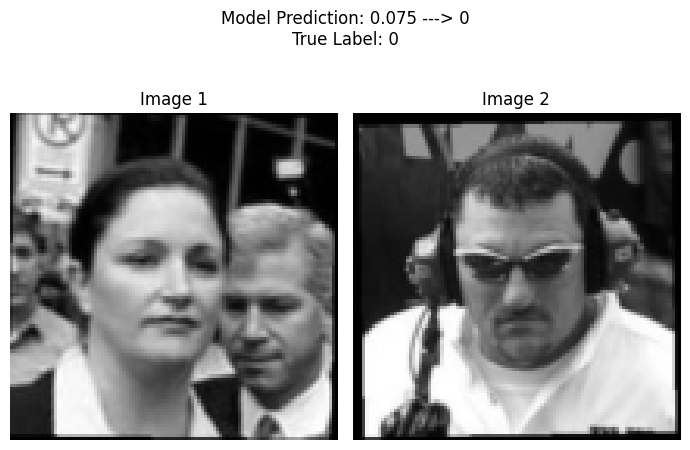

Correct Classification


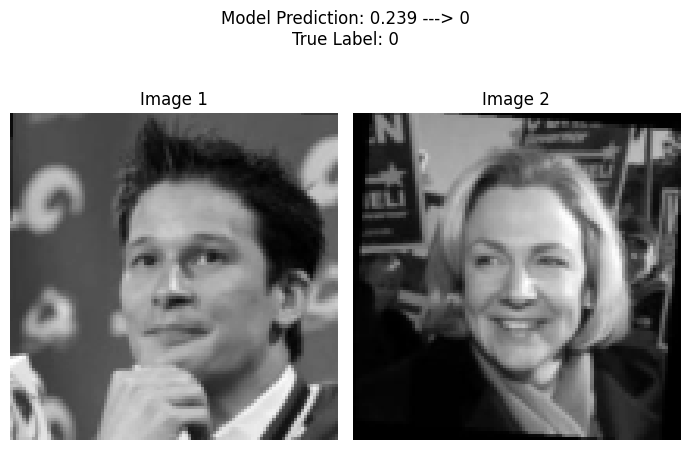

Correct Classification


In [35]:
# Visualize 20 examples (accurate and misclassified) from the test set
visualize_predictions(model, test_loader, device, num_examples=20)

# Example Images

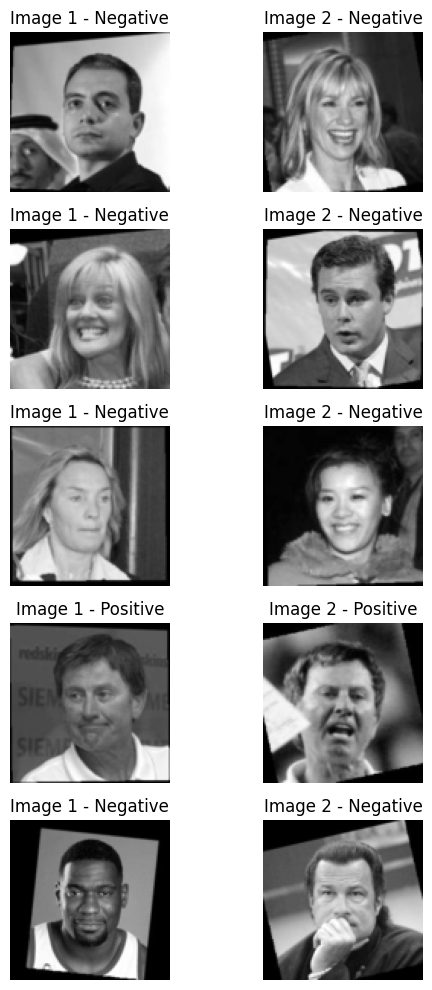

In [30]:
def visualize_pairs(dataloader, num_pairs=5):
    """
    Visualizes example image pairs (positive and negative) from the dataset.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader containing image pairs and labels.
        num_pairs (int): Number of pairs to display.
    """
    model.eval()  # Ensure the model is in evaluation mode
    shown_pairs = 0
    plt.figure(figsize=(6, num_pairs * 2))

    for (img1, img2), label in dataloader:
        for i in range(len(label)):
            if shown_pairs >= num_pairs:
                break

            # Prepare images for plotting
            img1_np = img1[i].squeeze().cpu().numpy()
            img2_np = img2[i].squeeze().cpu().numpy()
            pair_label = "Positive" if label[i].item() == 1 else "Negative"

            # Plot the pair
            plt.subplot(num_pairs, 2, 2 * shown_pairs + 1)
            plt.imshow(img1_np, cmap="gray")
            plt.title(f"Image 1 - {pair_label}")
            plt.axis("off")

            plt.subplot(num_pairs, 2, 2 * shown_pairs + 2)
            plt.imshow(img2_np, cmap="gray")
            plt.title(f"Image 2 - {pair_label}")
            plt.axis("off")

            shown_pairs += 1

        if shown_pairs >= num_pairs:
            break

    plt.tight_layout()
    plt.show()


visualize_pairs(train_loader, num_pairs=5)